In [1]:
from fit.datamodules.super_res import CelebA_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
seed_everything(22122020)

Global seed set to 22122020


22122020

In [3]:
dm = CelebA_SResFITDM(root_dir='./datamodules/data/CelebA/', batch_size=32)
dm.prepare_data()
dm.setup()

In [4]:
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

In [5]:
n_heads = 8
d_query = 32

In [6]:
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1)

In [7]:
trainer = Trainer(max_epochs=100, 
                  gpus=1,
                  callbacks=[ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_loss',
                                            mode='min'
                                        )], 
                  deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
# Train your own model.
# trainer.fit(model, datamodule=dm);

In [9]:
if not exists('./models/sres/celeb_sres.ckpt'):
    wget.download('https://download.fht.org/jug/fit/sres_model_celeb.ckpt',
                  out='./models/sres/celeb_sres.ckpt')

In [10]:
model.load_test_model('./models/sres/celeb_sres.ckpt')
model.cpu();

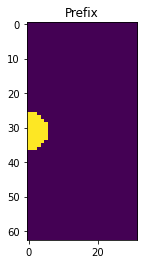

In [11]:
num_rings = 6

x, y = np.meshgrid(range(model.dft_shape[1]), range(-model.dft_shape[0] // 2 + 1, model.dft_shape[0] // 2 + 1))
radii = np.sqrt(x ** 2 + y ** 2, dtype=np.float32)
selected_rings = np.round(radii) < num_rings

model.input_seq_length = np.sum(selected_rings)
plt.imshow(selected_rings)
plt.title('Prefix');

In [12]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

In [13]:
lowres, pred_img, gt = model.get_lowres_pred_gt(fc, mag_min, mag_max)

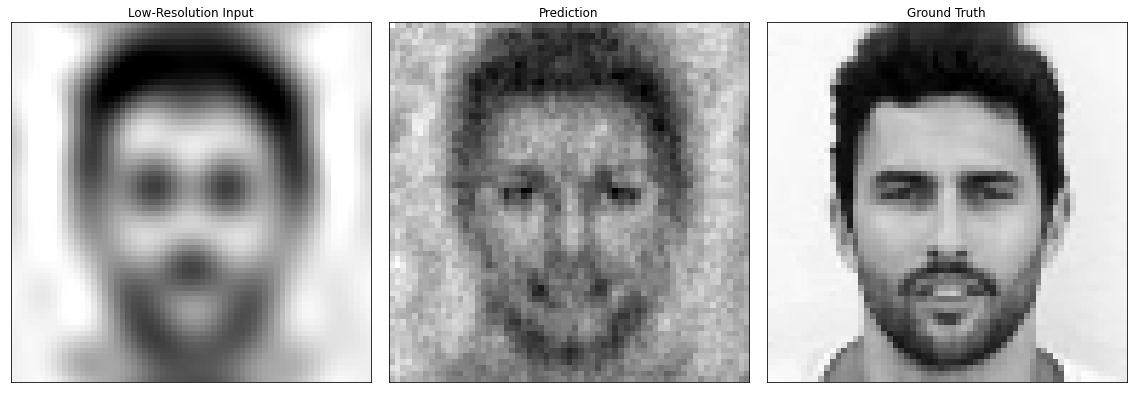

In [14]:
sample = 30
fig = plt.figure(figsize=(31/2., 10/2.)) 
gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[4])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.imshow(lowres[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
ax0.set_title('Low-Resolution Input');
ax0.axis('equal');

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.imshow(pred_img[sample], cmap='gray')#, vmin=gt[sample].min(), vmax=gt[sample].max())
ax1.set_title('Prediction');
ax1.axis('equal');


ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.imshow(gt[sample], cmap='gray')
ax2.set_title('Ground Truth');
ax2.axis('equal');